# Projeto de aprendizagem não supervisionada

Neste projeto você deverá detectar anomalias em tráfego de passageiros em táxis na cidade de Nova York. O conjunto de dados consiste em uma série temporal do número de passageiros em táxis agregados em uma janela de tempo de 30 minutos. Os dados foram retirados do [Kaggle](https://www.kaggle.com/boltzmannbrain/nab).

## Extração de características

Antes de realizar a detecção de anomalias você deve extrair as características desejadas baseada na data e hora. Extraia as seguintes características:

* O horário a partir de uma data de referência.
* O dia da semana
* Se o dia é um dia da semana ou final de semana
* A hora
* Se a hora está em um horário de pico (defina quais horários de pico você utilizará).
* Uma nova característica de sua escolha (você pode utilizar a combinação de características definidas anteriormente).

## Análise dos dados

Faça uma breve análise dos dados:

* Visualize a quantidade de passageiros ao longo do tempo.
    * Existe muita variação na quantidade de passageiros? Existem muitos picos ou vales?
* Visualize a quantidade de passageiros a cada hora.
    * Os horários de pico que você definiu anteriormente são adequados? Se não for, ajuste os horários.

## Detecção de anomalias

Agora você deve realizar a detecção de anomalias:

* Normalize os dados para uma escala comum.
* Faça a detecção de anomalias através do Isolation Forest.
* Faça a detecção de anomalias através do Elliptic Envelope.
* Faça a detecção de anomalias através do Local Outlier Factor.
* Visualize as anomalias ao longo do tempo para ambos algoritmos. Qual algoritmo teve resultados melhores? Por quê?
* Existem 5 eventos podem influenciar de forma anômala a quantidade de passageiros de táxi: a maratona de NY (02/11/2014), o Dia de Ação de Graças (27/11/2014), o Natal, o Ano Novo and a uma nevasca (26~27/01/2015). As anomalias apontadas pelos algoritmos incluem esses eventos?


In [0]:
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(22.7,8.27)})
palette = sns.color_palette("bright", 4)
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot as plt

nyc_taxi = pd.read_csv("https://orionwinter.github.io/datasets/nyc_taxi.csv")
outlier_frac = 0.001

In [307]:
nyc_taxi.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


## Extração de Caracteristicas

In [308]:
nyc_taxi['timestamp'] = pd.to_datetime(nyc_taxi['timestamp'])
nyc_taxi = nyc_taxi.assign(hour = nyc_taxi.timestamp.dt.hour)
nyc_taxi = nyc_taxi.assign(weekday = np.where(nyc_taxi.timestamp.dt.weekday < 5, 1 , 0))#0=mon to fri; 1= sat, sun
nyc_taxi = nyc_taxi.assign(rush_hour = np.where(((nyc_taxi.hour>=7) & (nyc_taxi.hour<=9) | (nyc_taxi.hour>=17) & (nyc_taxi.hour<=22)), 1 , 0))#0=No,1=Yes
nyc_taxi['rush_hour'] = nyc_taxi['rush_hour']*nyc_taxi['weekday']#Deconsidera os finais de semana do horário do rush.
nyc_taxi = nyc_taxi.assign(dayofweek = nyc_taxi.timestamp.dt.dayofweek)
nyc_taxi['time_epoch'] = (nyc_taxi['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
nyc_taxi.query('rush_hour ==0 & hour == 7')

,timestamp,value,hour,weekday,rush_hour,dayofweek,time_epoch
206,2014-07-05 07:00:00,3658,7,0,0,5,14045436
207,2014-07-05 07:30:00,4345,7,0,0,5,14045454
254,2014-07-06 07:00:00,3189,7,0,0,6,14046300
255,2014-07-06 07:30:00,4107,7,0,0,6,14046318
542,2014-07-12 07:00:00,5347,7,0,0,5,14051484
...,...,...,...,...,...,...,...
9951,2015-01-24 07:30:00,6401,7,0,0,5,14220846
9998,2015-01-25 07:00:00,4009,7,0,0,6,14221692
9999,2015-01-25 07:30:00,5014,7,0,0,6,14221710
10286,2015-01-31 07:00:00,4803,7,0,0,5,14226876


## Análise de Dados

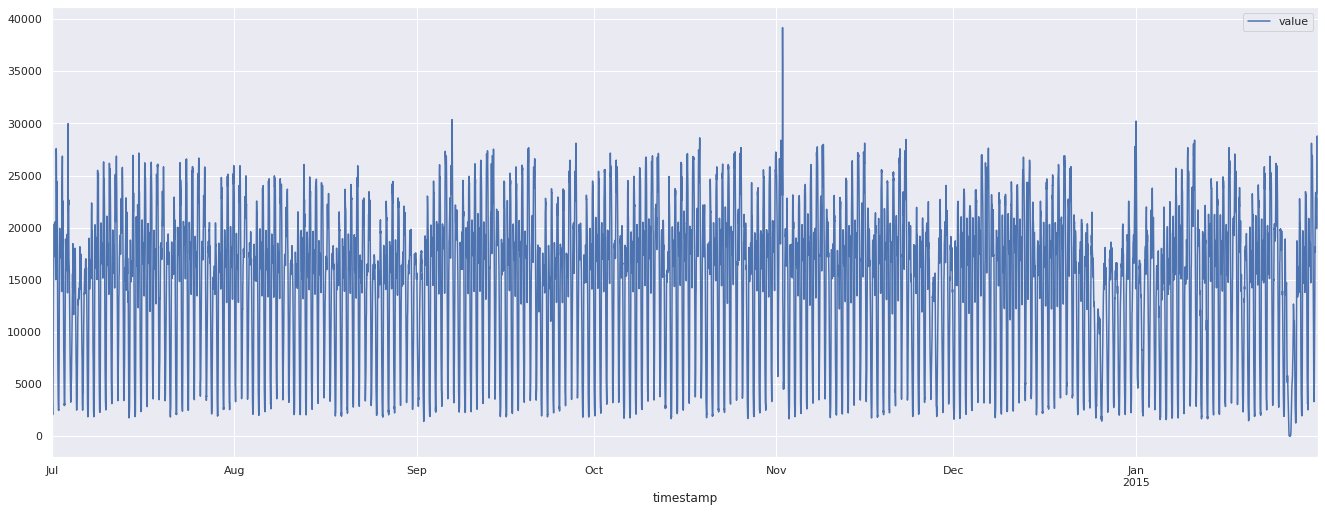

In [309]:
nyc_taxi.plot(x='timestamp', y='value')

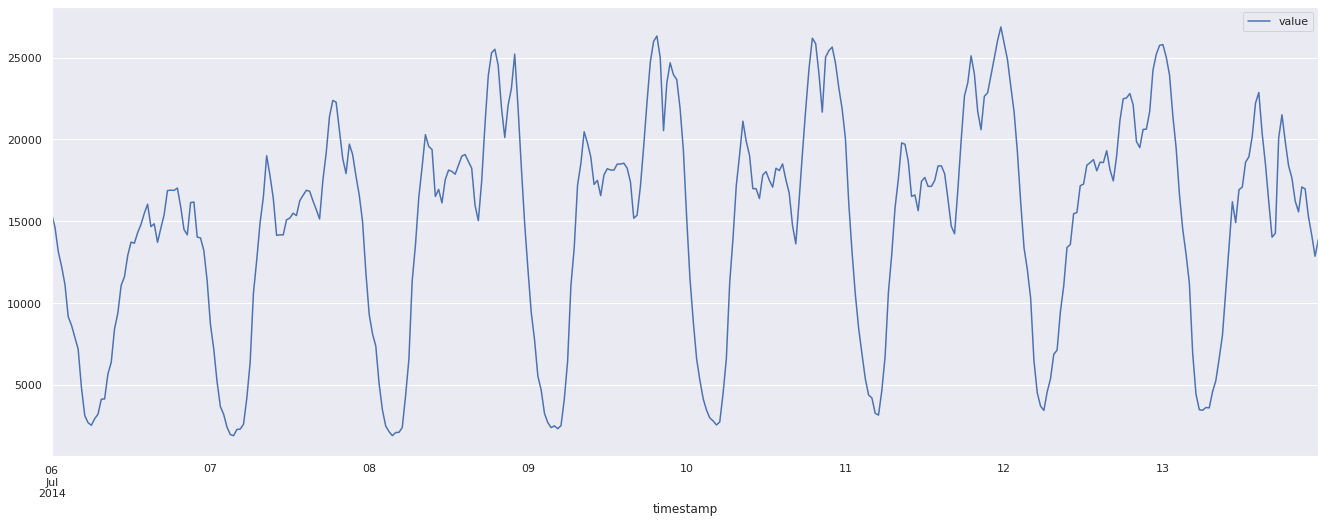

In [310]:
nyc_taxi.query("timestamp >= '2014-07-06 00:00:00' & timestamp <= '2014-07-13 23:59:59'").plot(x='timestamp', y='value')

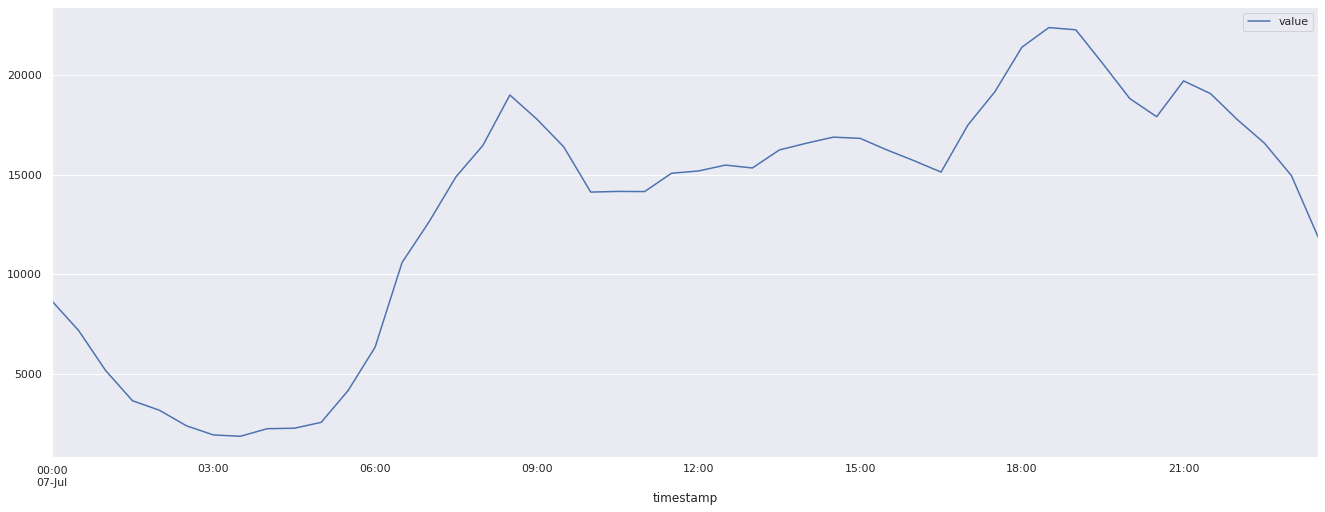

In [311]:
nyc_taxi.query("timestamp >= '2014-07-07 00:00:00' & timestamp <= '2014-07-07 23:59:59'").plot(x='timestamp', y='value')

* Visualize a quantidade de passageiros ao longo do tempo.
    * Existe muita variação na quantidade de passageiros? Existem muitos picos ou vales? R: O horário da madrugrada tem poucos passageiros, ficando mais ou menos estável ao entre as 7 e as 22hs com o pico de passageiros as 21hs.
* Visualize a quantidade de passageiros a cada hora.
    * Os horários de pico que você definiu anteriormente são adequados? Se não for, ajuste os horários. R: O horário de pico definido incialmente para a parte da tarde não condizia com a realidade. Inicialmente tinha colocado um valor entre as 17 e as 19 horas, mas notei pelo grafico temporal que o horário de pico se estende até as 22hs. Já na parte da manhã, não houve alteração.

## Detecção de anomalias

* Normalize os dados para uma escala comum

In [312]:
nyc_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 7 columns):
timestamp     10320 non-null datetime64[ns]
value         10320 non-null int64
hour          10320 non-null int64
weekday       10320 non-null int64
rush_hour     10320 non-null int64
dayofweek     10320 non-null int64
time_epoch    10320 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 564.5 KB


In [0]:
#nyc_taxi = nyc_taxi.drop(columns=['timestamp'])
data = nyc_taxi[['value','hour','weekday','rush_hour','dayofweek','time_epoch']]
min_max_scaler = preprocessing.StandardScaler()
data_scaled = min_max_scaler.fit_transform(data)

* Faça a detecção de anomalias através do Isolation Forest.


In [314]:
model = IsolationForest(contamination=outliers_faction)
model.fit(data_scaled)
nyc_taxi['anomaly_IF'] = pd.Series(model.predict(data_scaled))
nyc_taxi['anomaly_IF'] = nyc_taxi['anomaly_IF'].map({1:0, -1:1})
print(nyc_taxi['anomaly_IF'].value_counts())

0    10216
1      104
Name: anomaly_IF, dtype: int64


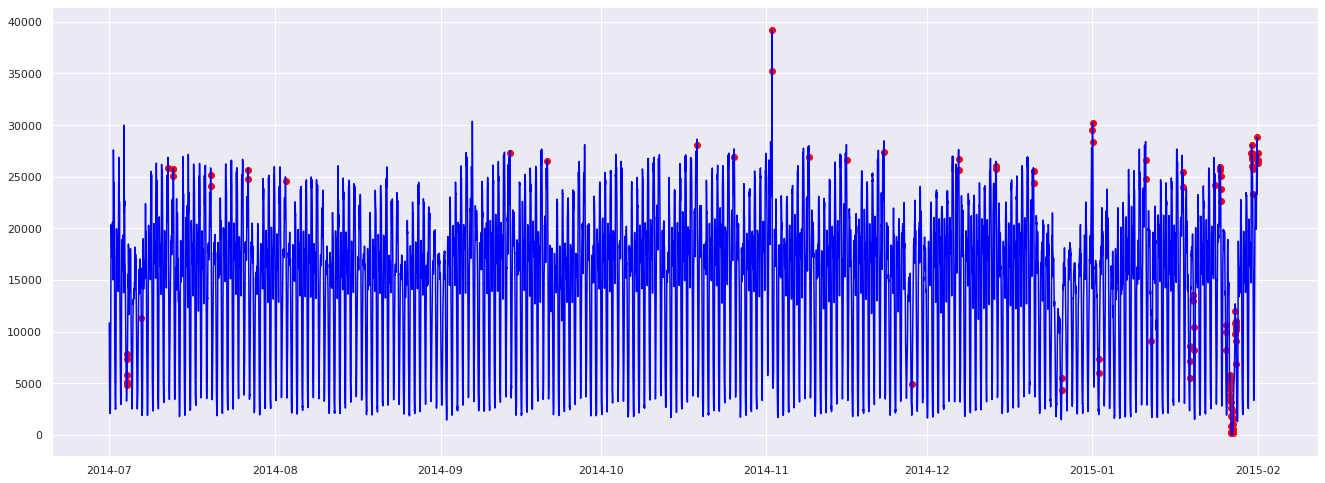

In [315]:
fig, ax = plt.subplots()

a = nyc_taxi.loc[nyc_taxi['anomaly_IF'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(nyc_taxi['timestamp'], nyc_taxi['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

* Faça a detecção de anomalias através do Elliptic Envelope.


In [316]:
ell = EllipticEnvelope(contamination=outlier_frac)
ell.fit(data_scaled)

# Binary prediction of normal vs. outlier
nyc_taxi['anomaly_EE'] = pd.Series(ell.predict(data_scaled))
nyc_taxi['anomaly_EE'] = nyc_taxi['anomaly_EE'].map({1:0, -1:1})
print(nyc_taxi['anomaly_EE'].value_counts())

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.637560671695054 > -70.855296632664007). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.716669171764026 > -70.893986952788325). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.646990971664506 > -70.869417121612884). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
/usr/local/lib/pyth

0    10309
1       11
Name: anomaly_EE, dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.921125561103344 > -67.417380507581214). You may want to try with a higher value of support_fraction (current value: 0.500).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.941038468864525 > -67.422120262515193). You may want to try with a higher value of support_fraction (current value: 0.500).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.911245019929527 > -67.411829946131206). You may want to try with a higher value of support_fraction (current value: 0.500).
  RuntimeWarning)
/usr/local/lib/pyth

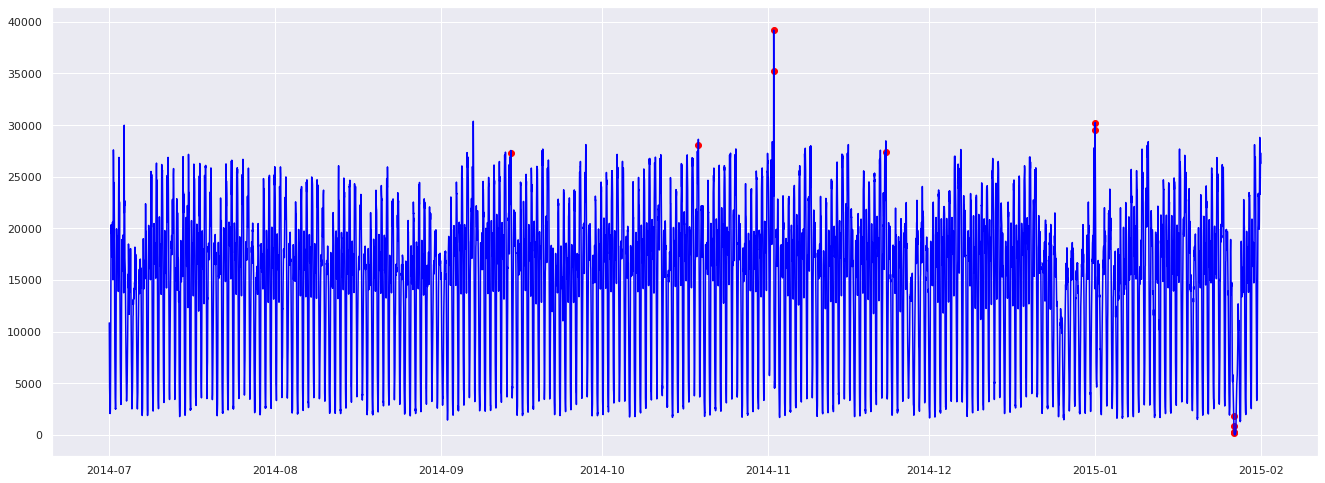

In [317]:
fig, ax = plt.subplots()

a = nyc_taxi.loc[nyc_taxi['anomaly_EE'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(nyc_taxi['timestamp'], nyc_taxi['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

* Faça a detecção de anomalias através do Local Outlier Factor.


In [318]:
clf = LocalOutlierFactor(n_neighbors=30, contamination=outlier_frac)
y_pred = clf.fit_predict(data_scaled)

nyc_taxi['anomaly_LOF'] = pd.Series(model.predict(data_scaled))
nyc_taxi['anomaly_LOF'] = nyc_taxi['anomaly_LOF'].map({1:0, -1:1})
print(nyc_taxi['anomaly_LOF'].value_counts())

0    10216
1      104
Name: anomaly_LOF, dtype: int64


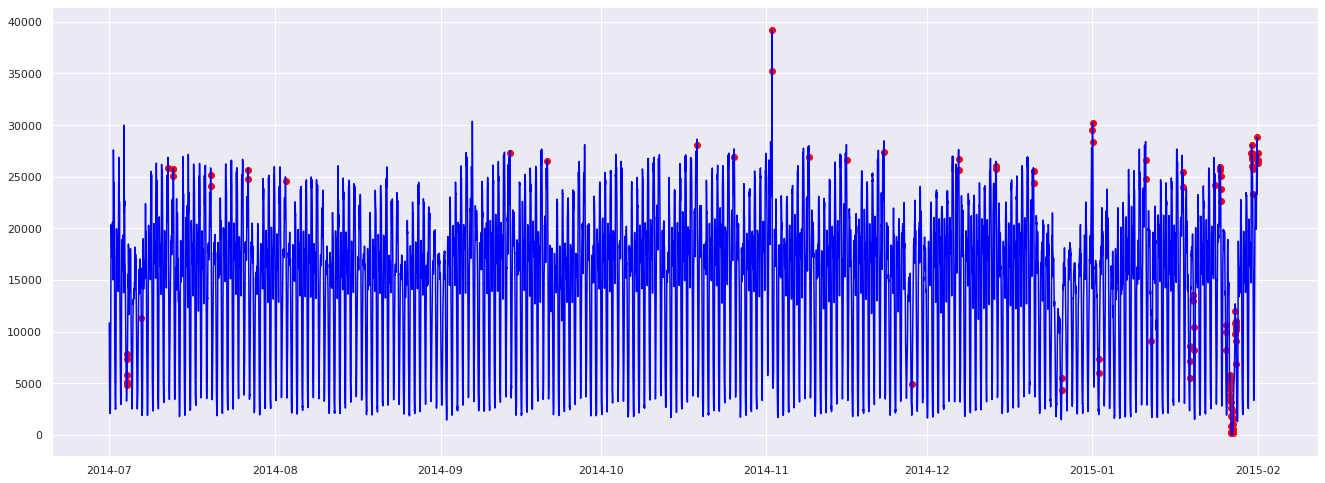

In [319]:
fig, ax = plt.subplots()

a = nyc_taxi.loc[nyc_taxi['anomaly_LOF'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(nyc_taxi['timestamp'], nyc_taxi['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

* Visualize as anomalias ao longo do tempo para ambos algoritmos. Qual algoritmo teve resultados melhores? Por quê? R:


R: Após calibrar a variável outlier_frac para 0.001, podemos observar que o algoritmo que melhor detectou ous outliers foi o Eliptic Envelop, por ter identificado menos falsos outliers. O Isolation Forest e o Local Outlier Factor, por outro lado, identificaram muitos falsos outliers.

* Existem 5 eventos podem influenciar de forma anômala a quantidade de passageiros de táxi: a maratona de NY (02/11/2014), o Dia de Ação de Graças (27/11/2014), o Natal, o Ano Novo and a uma nevasca (26~27/01/2015). As anomalias apontadas pelos algoritmos incluem esses eventos?

In [329]:
nyc_taxi.query("anomaly_IF ==1")

,timestamp,value,hour,weekday,rush_hour,dayofweek,time_epoch,anomaly_IF,anomaly_EE,anomaly_LOF
158,2014-07-04 07:00:00,4828,7,1,1,4,14044572,1,0,1
159,2014-07-04 07:30:00,4926,7,1,1,4,14044590,1,0,1
160,2014-07-04 08:00:00,5165,8,1,1,4,14044608,1,0,1
161,2014-07-04 08:30:00,5776,8,1,1,4,14044626,1,0,1
162,2014-07-04 09:00:00,7338,9,1,1,4,14044644,1,0,1
...,...,...,...,...,...,...,...,...,...,...
10273,2015-01-31 00:30:00,23304,0,0,0,5,14226642,1,0,1
10310,2015-01-31 19:00:00,28804,19,0,0,5,14227308,1,0,1
10317,2015-01-31 22:30:00,27309,22,0,0,5,14227434,1,0,1
10318,2015-01-31 23:00:00,26591,23,0,0,5,14227452,1,0,1


In [330]:
nyc_taxi.query("anomaly_EE ==1")

,timestamp,value,hour,weekday,rush_hour,dayofweek,time_epoch,anomaly_IF,anomaly_EE,anomaly_LOF
3600,2014-09-14 00:00:00,27320,0,0,0,6,14106528,1,1,1
5280,2014-10-19 00:00:00,28093,0,0,0,6,14136768,1,1,1
5954,2014-11-02 01:00:00,39197,1,0,0,6,14148900,1,1,1
5955,2014-11-02 01:30:00,35212,1,0,0,6,14148918,1,1,1
6960,2014-11-23 00:00:00,27424,0,0,0,6,14167008,1,1,1
8833,2015-01-01 00:30:00,29547,0,1,0,3,14200722,1,1,1
8834,2015-01-01 01:00:00,30236,1,1,0,3,14200740,1,1,1
10076,2015-01-26 22:00:00,1783,22,1,1,0,14223096,1,1,1
10077,2015-01-26 22:30:00,866,22,1,1,0,14223114,1,1,1
10078,2015-01-26 23:00:00,297,23,1,0,0,14223132,1,1,1


In [331]:
nyc_taxi.query("anomaly_LOF ==1")

,timestamp,value,hour,weekday,rush_hour,dayofweek,time_epoch,anomaly_IF,anomaly_EE,anomaly_LOF
158,2014-07-04 07:00:00,4828,7,1,1,4,14044572,1,0,1
159,2014-07-04 07:30:00,4926,7,1,1,4,14044590,1,0,1
160,2014-07-04 08:00:00,5165,8,1,1,4,14044608,1,0,1
161,2014-07-04 08:30:00,5776,8,1,1,4,14044626,1,0,1
162,2014-07-04 09:00:00,7338,9,1,1,4,14044644,1,0,1
...,...,...,...,...,...,...,...,...,...,...
10273,2015-01-31 00:30:00,23304,0,0,0,5,14226642,1,0,1
10310,2015-01-31 19:00:00,28804,19,0,0,5,14227308,1,0,1
10317,2015-01-31 22:30:00,27309,22,0,0,5,14227434,1,0,1
10318,2015-01-31 23:00:00,26591,23,0,0,5,14227452,1,0,1


Como pode ser visto, pela inspeção dos dados, o Elipic Envelop conseguiu capturar rasoavelmente bem os outliers dos eventos citados no enunciado, sem, contudo, apontar muitos falsos outliers. Todos os algoritmos foram capazes de identificar os outliers do enunciado, porém o Isolation Forest e o Local Outlier Factor identificar muitos falso outliers (aparenemente). Outro ponto a ser destado é que a quantidade de outliers encontrados pelos dois últimos algoritmos foi igual.